In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import math

In [2]:
src_base_w = 32
src_base_h = 32
iso_base_w = 64 * 2
iso_base_h = 32 * 2

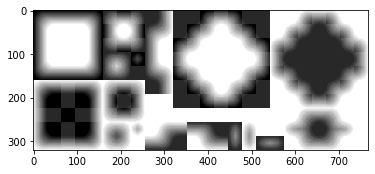

[0, 8, 16, 24, 32, 40, 43, 48, 50, 56, 63, 64, 70, 72, 76, 80, 83, 88, 90, 96, 103, 104, 110, 112, 116, 120, 123, 128, 130, 136, 143, 144, 149, 152, 156, 160, 163, 168, 169, 176, 183, 184, 189, 192, 196, 200, 203, 208, 209, 216, 223, 224, 229, 232, 236, 240, 243, 248, 249, 256]


array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [4]:
img_filename = 'landh-tiles/TilesTest.png'
hmap = None
with Image.open(img_filename) as im_v:
    rgb_im_v = im_v.convert('RGBA')
    pixels = rgb_im_v.load()

    hmap = np.zeros(im_v.size)
    levels_of_gray = set()

    for sy in range(rgb_im_v.size[1]):
        for sx in range(rgb_im_v.size[0]):
            c = r, g, b, a = pixels[sx, sy]
            vmap = max(r, g, b)
            if vmap <= 1:   vmap = 0
            if vmap >= 255: vmap = 256
            levels_of_gray.add(vmap)

            num_gray_levels = 32
            vmap = int(min(num_gray_levels - 0, vmap * num_gray_levels / 256 )) * 256 // num_gray_levels

            levels_of_gray.add(vmap)
            hmap[sx, sy] = float(vmap / 256.)
            pixels[sx, sy] = (vmap, vmap, vmap, 255)

plt.imshow(rgb_im_v)
plt.show()

del rgb_im_v
del pixels

print(sorted(levels_of_gray))

hmap

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def bezier_gradient(ref_colors, output_num=100):
    n_ref = len(ref_colors) - 1

    fact_cache = {}
    def fact(n):
        ''' Memorized factorial function '''
        try:
            return fact_cache[n]
        except(KeyError):
            if n == 1 or n == 0:
                result = 1
            else:
                result = n*fact(n-1)
            fact_cache[n] = result
            return result

    def bernstein(t, n, i):
        ''' Bernstein coefficient '''
        binom = fact(n)/float(fact(i)*fact(n - i))
        return binom*((1-t)**(n-i))*(t**i)

    def bezier_interp(t):
            ''' Define an interpolation function
                for this specific curve'''
            # List of all summands
            summands = [
                list(map(lambda x: int(bernstein(t, n_ref, i)*x), c)) for i, c in enumerate(ref_colors)
            ]

            # Output color
            out = [0,0,0]
            # Add components of each summand together
            for vector in summands:
                for c in range(3):
                    out[c] += vector[c]

            return out

    gradient = [
        bezier_interp(float(t)/(output_num-1)) for t in range(output_num)
    ]
    return gradient

ref_colors = [(0,0,255), (0, 230, 64), (255, 203, 5)]

print(ref_colors)
num_colors = 256 // 16

gradient = bezier_gradient(ref_colors, num_colors)
print(gradient)

[(0, 0, 255), (0, 230, 64), (255, 203, 5)]
[[0, 0, 255], [1, 28, 229], [4, 56, 205], [10, 81, 183], [18, 103, 162], [28, 124, 141], [40, 142, 121], [55, 158, 104], [72, 171, 87], [91, 183, 71], [113, 192, 58], [137, 198, 45], [163, 202, 33], [191, 205, 21], [222, 204, 12], [255, 203, 5]]


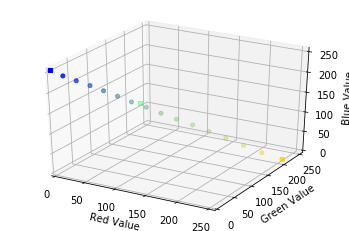

In [9]:
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]


def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
                        "{0:x}".format(v) for v in RGB])

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
        colors in RGB and hex form for use in a graphing function
        defined later on '''
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def control_points_from_colors(gradient):
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def plot_gradient_series(color_dict, pointsize=100, control_points=None, filename=None):
        ''' Take a dictionary containing the color
            gradient in RBG and hex form and plot
            it to a 3D matplotlib device '''

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        xcol = color_dict["r"]
        ycol = color_dict["g"]
        zcol = color_dict["b"]

        # If bezier control points passed to function,
        # plot along with curve
        if control_points != None:
            xcntl = control_points["r"]
            ycntl = control_points["g"]
            zcntl = control_points["b"]
            ax.scatter( xcntl, ycntl, zcntl,
                        c=control_points["hex"],
                        s=pointsize, marker='s')

        # We can pass a vector of colors corresponding to each point
        ax.scatter(xcol, ycol, zcol, c=color_dict["hex"], s=pointsize)

        ax.set_xlabel('Red Value')
        ax.set_ylabel('Green Value')
        ax.set_zlabel('Blue Value')
        ax.set_zlim3d(0,255)
        plt.ylim(0,255)
        plt.xlim(0,255)

        if not filename is None:
            # Save two views of each plot
            ax.view_init(elev=15, azim=68)
            plt.savefig(filename + ".svg")
            ax.view_init(elev=15, azim=28)
            plt.savefig(filename + "_view_2.svg")

        # Show plot for testing
        plt.show()

plot_gradient_series(color_dict(gradient),
                     pointsize=num_colors,
                     control_points=control_points_from_colors(ref_colors)
                    )

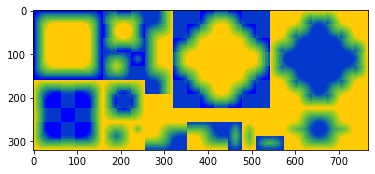

In [10]:
img = Image.new('RGBA', hmap.shape, color = 'black')
pixels = img.load()
max_x, max_y = img.size

for y in range(max_y):
	for x in range(max_x):
		v = int(hmap[x, y] * len(gradient))
		r, g, b = gradient[min(v, len(gradient)-1)]
		pixels[x, y] = (r, g, b, 255)

plt.imshow(img)
plt.show()

del pixels
del img

In [ ]:
import csv

tiles_info = []
with open('landh-tiles/TilesTest.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        tiles_info.append(row)
        line_count += 1
    print(f'Processed {line_count} lines.')
    print(f'Found {len(tiles_info)} tiles.')

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '7'), ('Comment', 'Floor')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


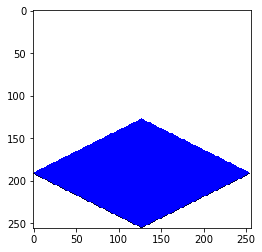

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '2'), ('Comment', 'Plateau')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


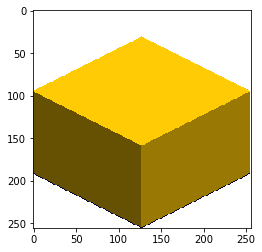

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '0'), ('Comment', 'Descending N-S')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


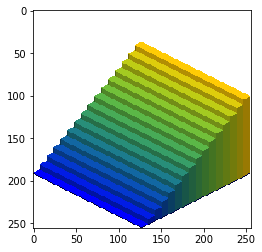

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '4'), ('Comment', 'Descending S-N')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


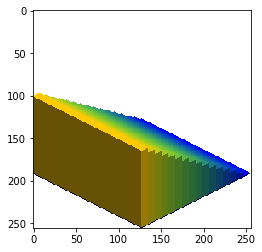

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '2'), ('Comment', 'Descending W-E')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


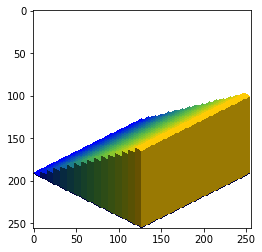

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '2'), ('Comment', 'Descending E-W')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


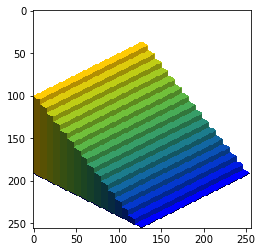

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '0'), ('Comment', 'Ascending Corner NW-SE')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


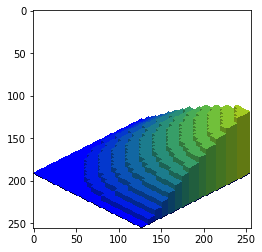

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '0'), ('Comment', 'Ascending Corner NE-SW')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


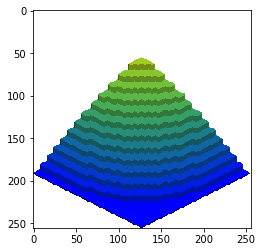

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '4'), ('Comment', 'Ascending Corner SW-NE')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


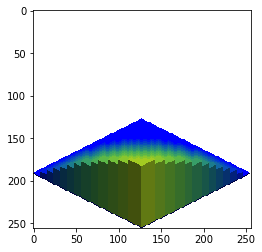

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '4'), ('Comment', 'Ascending Corner SE-NW')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


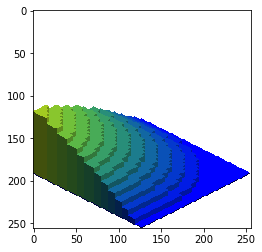

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '5'), ('Comment', 'Descending Corner NW-SE')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


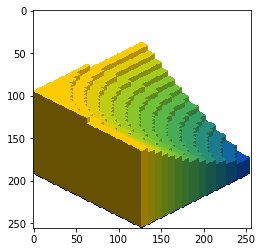

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '5'), ('Comment', 'Descending Corner NE-SW')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


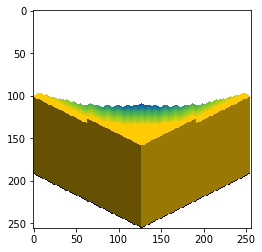

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '9'), ('Comment', 'Descending Corner SW-NE')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


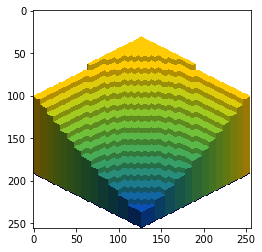

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '9'), ('Comment', 'Descending Corner SE-NW')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


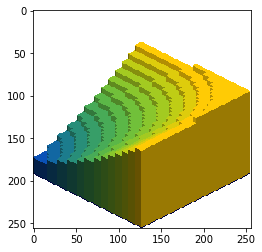

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '1'), ('Comment', 'Ascending Corner NWW-E')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


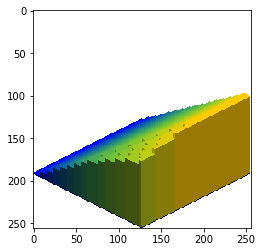

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '1'), ('Comment', 'Ascending Corner NEE-W')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


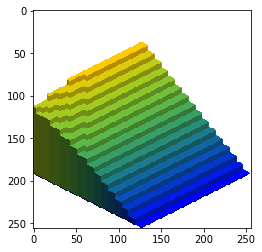

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '3'), ('Comment', 'Ascending Corner SWW-E')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


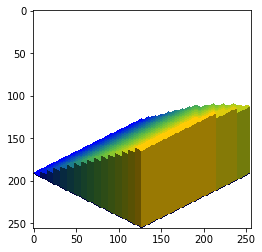

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '3'), ('Comment', 'Ascending Corner SEW-W')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


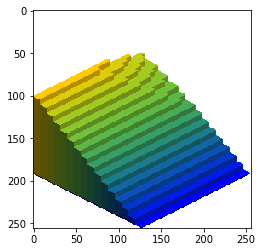

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '0'), ('Comment', 'Ascending Corner NNW-S')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


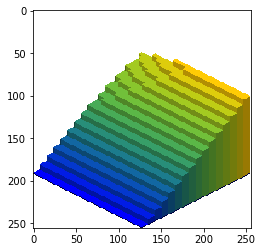

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '0'), ('Comment', 'Ascending Corner NNE-S')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


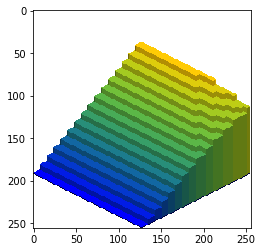

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '4'), ('Comment', 'Ascending Corner SSW-N')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


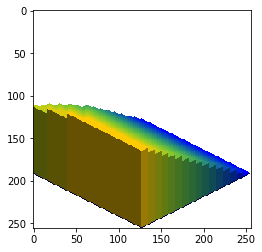

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '4'), ('Comment', 'Ascending Corner SSE-N')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


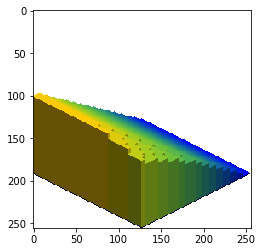

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '6'), ('Comment', 'Descending Corner NWW-E')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


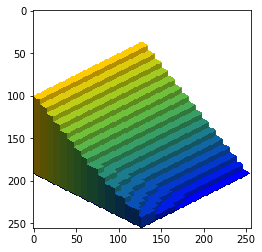

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '6'), ('Comment', 'Descending Corner NEE-W')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


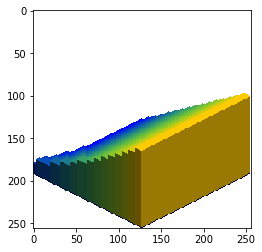

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '8'), ('Comment', 'Descending Corner SWW-E')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


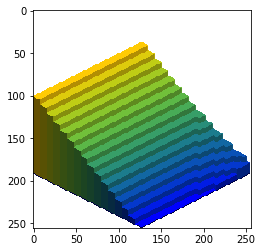

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '8'), ('Comment', 'Descending Corner SEW-W')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


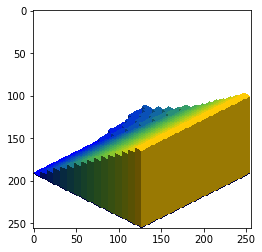

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '5'), ('Comment', 'Descending Corner NNW-S')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


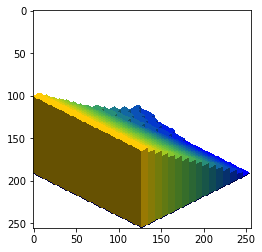

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '5'), ('Comment', 'Descending Corner NNE-S')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


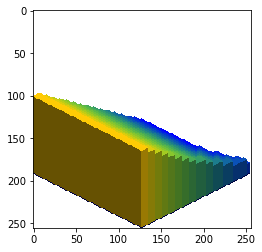

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '9'), ('Comment', 'Descending Corner SSW-N')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


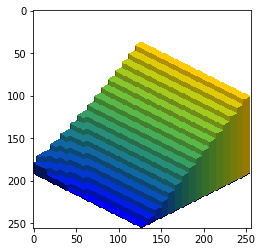

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '9'), ('Comment', 'Descending Corner SSE-N')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


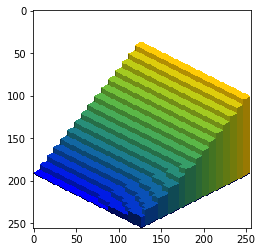

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '1'), ('Comment', 'Plateau NW')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


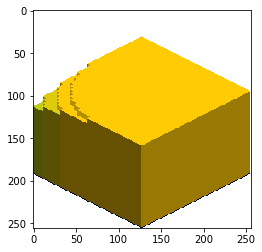

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '1'), ('Comment', 'Plateau NE')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


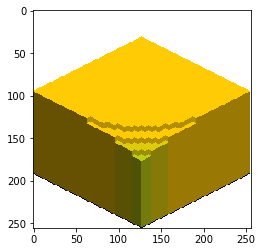

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '3'), ('Comment', 'Plateau SW')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


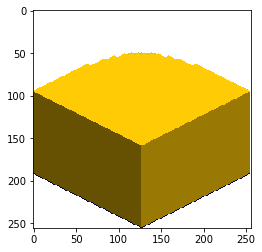

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '3'), ('Comment', 'Plateau SE')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


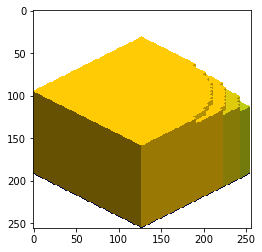

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '6'), ('Comment', 'Floor NW')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


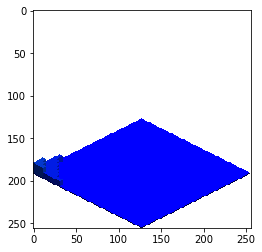

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '6'), ('Comment', 'Floor NE')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


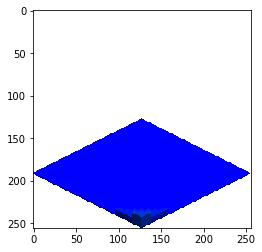

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '8'), ('Comment', 'Floor SW')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


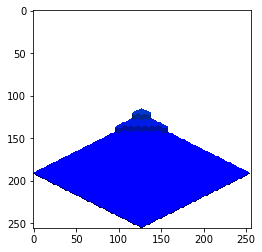

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '8'), ('Comment', 'Floor SE')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


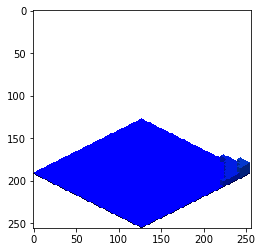

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '0'), ('Comment', 'Ascending Corner N')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


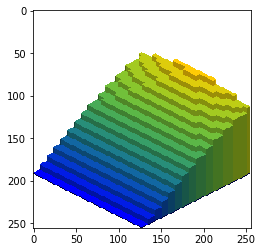

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '2'), ('Comment', 'Ascending Corner S')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


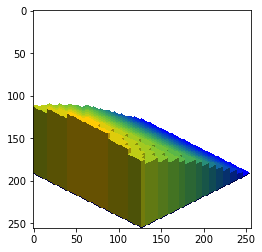

OrderedDict([('TileName', ''), ('XCoord', '5'), ('YCoord', '1'), ('Comment', 'Ascending Corner W')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


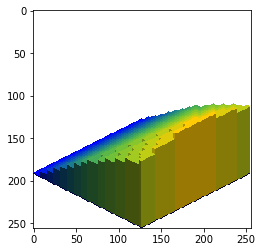

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '1'), ('Comment', 'Ascending Corner E')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


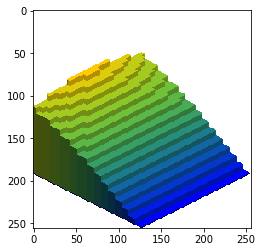

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '5'), ('Comment', 'Descending Corner N')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


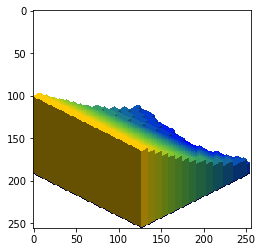

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '7'), ('Comment', 'Descending Corner S')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


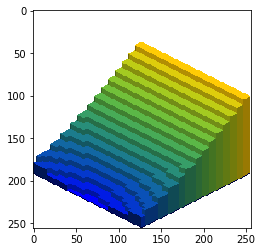

OrderedDict([('TileName', ''), ('XCoord', '5'), ('YCoord', '6'), ('Comment', 'Descending Corner W')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


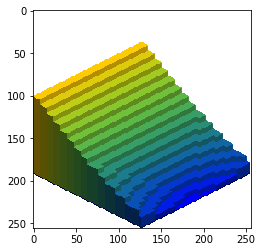

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '6'), ('Comment', 'Descending Corner E')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


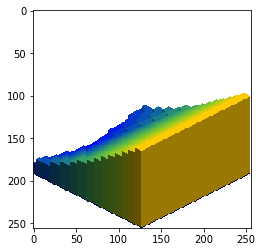

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '3'), ('Comment', 'Ascending Hole')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


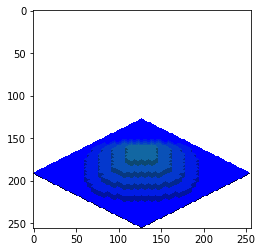

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '8'), ('Comment', 'Descending Hole')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


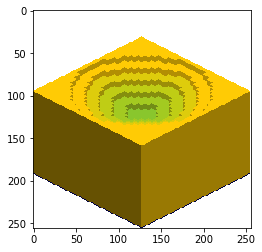

OrderedDict([('TileName', ''), ('XCoord', '10'), ('YCoord', '2'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


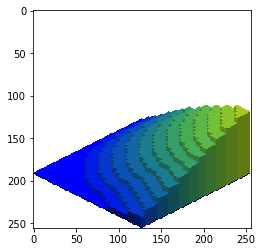

OrderedDict([('TileName', ''), ('XCoord', '11'), ('YCoord', '1'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


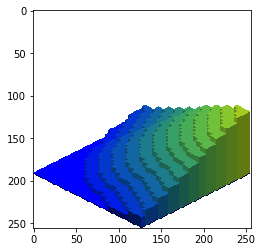

OrderedDict([('TileName', ''), ('XCoord', '12'), ('YCoord', '0'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


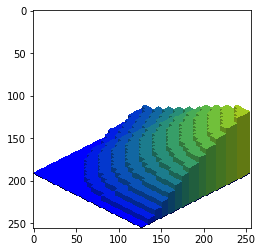

OrderedDict([('TileName', ''), ('XCoord', '14'), ('YCoord', '0'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


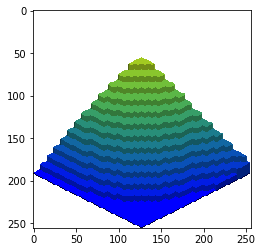

OrderedDict([('TileName', ''), ('XCoord', '15'), ('YCoord', '1'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


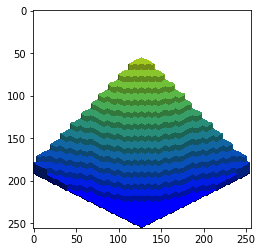

OrderedDict([('TileName', ''), ('XCoord', '16'), ('YCoord', '2'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


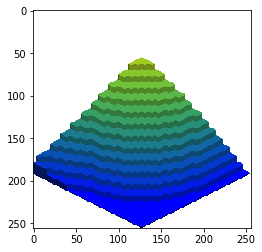

OrderedDict([('TileName', ''), ('XCoord', '10'), ('YCoord', '4'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


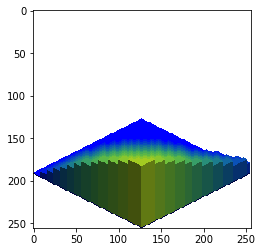

OrderedDict([('TileName', ''), ('XCoord', '11'), ('YCoord', '5'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


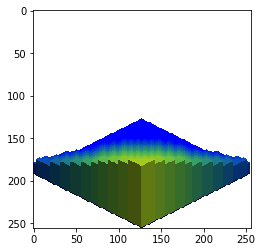

OrderedDict([('TileName', ''), ('XCoord', '12'), ('YCoord', '6'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


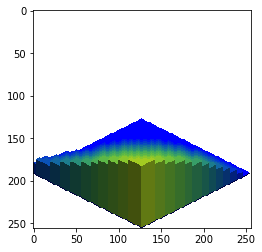

OrderedDict([('TileName', ''), ('XCoord', '14'), ('YCoord', '6'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


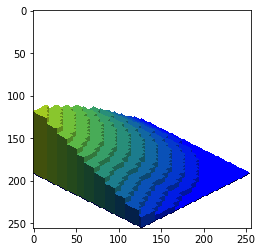

OrderedDict([('TileName', ''), ('XCoord', '15'), ('YCoord', '5'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


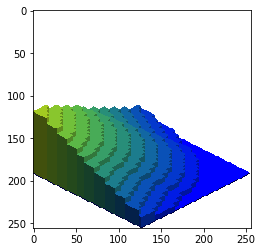

OrderedDict([('TileName', ''), ('XCoord', '16'), ('YCoord', '4'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


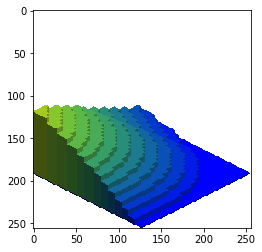

OrderedDict([('TileName', ''), ('XCoord', '17'), ('YCoord', '2'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


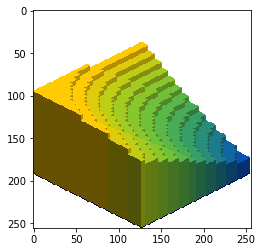

OrderedDict([('TileName', ''), ('XCoord', '18'), ('YCoord', '1'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


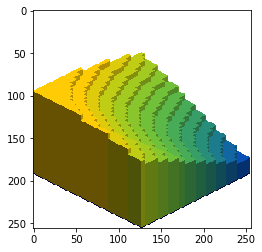

OrderedDict([('TileName', ''), ('XCoord', '19'), ('YCoord', '0'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


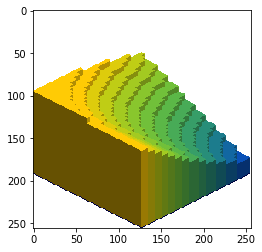

OrderedDict([('TileName', ''), ('XCoord', '21'), ('YCoord', '0'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


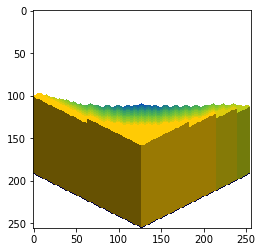

OrderedDict([('TileName', ''), ('XCoord', '22'), ('YCoord', '1'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


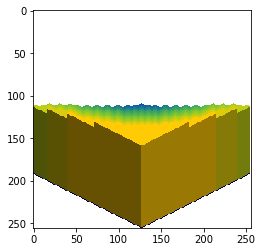

OrderedDict([('TileName', ''), ('XCoord', '23'), ('YCoord', '2'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


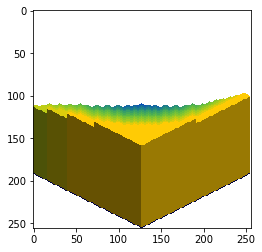

OrderedDict([('TileName', ''), ('XCoord', '17'), ('YCoord', '4'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


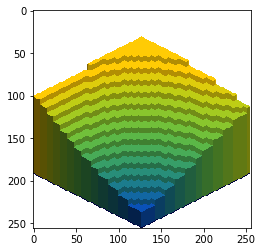

OrderedDict([('TileName', ''), ('XCoord', '18'), ('YCoord', '5'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


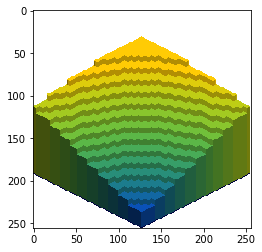

OrderedDict([('TileName', ''), ('XCoord', '19'), ('YCoord', '6'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


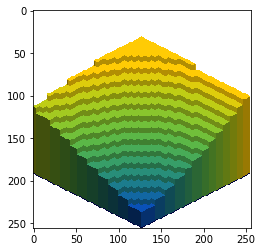

OrderedDict([('TileName', ''), ('XCoord', '21'), ('YCoord', '6'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


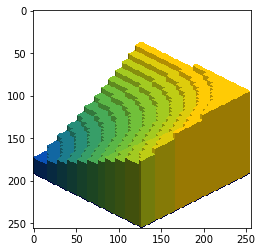

OrderedDict([('TileName', ''), ('XCoord', '22'), ('YCoord', '5'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


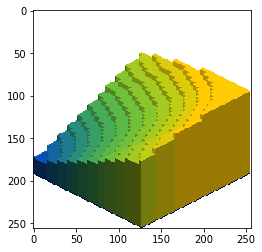

OrderedDict([('TileName', ''), ('XCoord', '23'), ('YCoord', '4'), ('Comment', '')])
sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


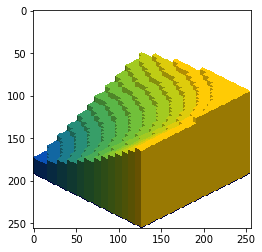

In [125]:
def draw_tile(hpos, vpos, tiles_scale=1., grad_offset=0, hfactor=1.5, show_floor=True, uvsub = 4, angle = math.pi/2.):
    #x0 = iso_base_w * scale / 2
    #y0 = 0

    xbase = 0
    ybase = 0

    num_gray_levels = 16

    hoff = src_base_w * hpos
    voff = src_base_h * vpos

    sin_angle = math.sin(angle)
    cos_angle = math.cos(angle)
    cpls_angle = cos_angle + sin_angle
    cmns_angle = cos_angle - sin_angle
    radius_x = (iso_base_w * tiles_scale / 2)
    radius_y = (iso_base_h * tiles_scale / 2)

    print(f"sin_angle = {sin_angle}, cos_angle = {cos_angle}, cpls_angle = {cpls_angle}, cmns_angle = {cmns_angle}")

    pixmap = np.zeros((
        iso_base_w * tiles_scale * uvsub,
        iso_base_h * tiles_scale * uvsub * 2,
        4))

    img = Image.new('RGBA', (
        iso_base_w * tiles_scale,
        iso_base_h * tiles_scale * 2),
        (0, 0, 0, 0))
    pixels = img.load()

    x0 = radius_x * (1. + sin_angle)
    y0 = img.size[1] - radius_y * (1. - cos_angle)

    max_vmap = int(256 * num_gray_levels) / num_gray_levels
    max_hc = int(hfactor * tiles_scale * max_vmap * 32 + 1)
    max_hc = 256
    for hc in range(0, max_hc):
        #print(f"hc = {hc}")
        h = 1. - float(hc / max_hc)

        max_vc = src_base_h * uvsub
        for raw_vc in range(max_vc):
            if cmns_angle >= 0:  vc = raw_vc
            else:                vc = max_vc - raw_vc - 1
            v = 1. - float(vc / src_base_h) / uvsub

            max_uc = src_base_w * uvsub
            for raw_uc in range(max_uc):
                if cpls_angle >= 0:  uc = raw_uc
                else:                uc = max_uc - raw_uc - 1
                u = 1. - float(uc / src_base_w) / uvsub

                x = x0 + radius_x * (u * cmns_angle - v * cpls_angle)
                y = y0 - radius_y * (u * cpls_angle + v * cmns_angle)

                vmap = hmap[uc // uvsub + hoff, vc // uvsub + voff]
                if vmap >= 1.: hlight = True
                else: hlight = False

                vmap = int(vmap * num_gray_levels) / num_gray_levels
                gr, gg, gb = gradient[min(grad_offset + int(vmap * 16), 15)]   
                maph = int(hfactor * tiles_scale * vmap * 32 + 1)

                if hc <= maph:
                    alpha = 1.
                    if show_floor or vmap > 0:
                        if hc == 0 and show_floor:
                            nr = 0
                            ng = 0
                            nb = 64
                        elif hc > maph:
                            continue
                        elif hc == maph:
                            nr = gr
                            ng = gg
                            nb = gb
                        else:
                            if uc == max_uc - 1:
                                factor = 0.6
                            elif vc == max_vc - 1:
                                factor = 0.8
                            elif uc == 0:
                                factor = 0.5
                            elif vc == 0:
                                factor = 0.4
                            else:
                                factor = 0.7
                                #continue

                            nr = gr * factor
                            ng = gg * factor
                            nb = gb * factor
                
                        tx2 = int((xbase + x) * uvsub)
                        ty2 = int((ybase + y - hc) * uvsub)

                        if alpha < 0.01:
                            continue

                        if alpha < 0.99:
                            pr = pixmap[tx2][ty2][0]
                            pg = pixmap[tx2][ty2][1]
                            pb = pixmap[tx2][ty2][2]
                            palpha = pixmap[tx2][ty2][3]

                            nr = nr * alpha + pr * (1. - alpha) * palpha
                            ng = ng * alpha + pg * (1. - alpha) * palpha
                            nb = nb * alpha + pb * (1. - alpha) * palpha
                            alpha = 1. - (1. - alpha) * (1. - palpha)

                        pixmap[tx2][ty2][0] = nr
                        pixmap[tx2][ty2][1] = ng
                        pixmap[tx2][ty2][2] = nb
                        pixmap[tx2][ty2][3] = alpha
                        
                        del tx2
                        del ty2

                        tx = int(xbase + x)
                        ty = int(ybase + y - hc)
                        pixels[tx, ty] = (int(nr), int(ng), int(nb), int(255 * alpha))
                        del tx
                        del ty

    return img, pixmap

tiles_scale = 2
for tile_info in tiles_info:
    print(tile_info)
    hpos, vpos = int(tile_info['XCoord']), int(tile_info['YCoord'])
    img, pixmap = draw_tile(hpos, vpos, tiles_scale=tiles_scale, angle = math.pi/2.)

    
    plt.imshow(img)
    plt.show()
    

In [213]:
vertices = {
        1: ( np.array((0., 0., 1.)), np.array((1., 0., 0., 1.)), np.array((0., 0.)) ),
        2: ( np.array((1., 0., 0.)), np.array((0., 1., 0., 1.)), np.array((0., 1.)) ),
        3: ( np.array((0., 1., 0.)), np.array((0., 0., 1., 1.)), np.array((1., 0.)) ),
        4: ( np.array((1., 1., 1.)), np.array((1., 0., 1., 1.)), np.array((1., 1.)) ),
}

triangles = [
    [1, 2, 3],
    [2, 3, 4],
]

tridata = []

for triangle in triangles:
    points = [vertices[v][0] for v in triangle]
    colors = [vertices[v][1] for v in triangle]
    texture = [vertices[v][2] for v in triangle]
    v1 = points[1] - points[0]
    v2 = points[2] - points[0]
    cp = np.cross(v1, v2) # the cross product is a vector normal to the plane
    a, b, c = cp
    d = np.dot(cp, points[0])
    assert(d == np.dot(cp, points[1]))
    assert(d == np.dot(cp, points[2]))
    print(f"Main plane equation is {a}·x + {b}·y + {c}·z = {d}")
    main_plane = [cp, -d]
    
    M = np.transpose(np.linalg.inv(np.array([v1, v2, cp])))
    assert(np.linalg.norm(np.dot(M, v1) - np.array((1., 0., 0.))) < 1e-8)
    assert(np.linalg.norm(np.dot(M, v2) - np.array((0., 1., 0.))) < 1e-8)
    mapping_data = [points[0], M]
    colors_map   = [colors[0], colors[1] - colors[0], colors[2] - colors[0]]
    texture_map  = [texture[0], texture[1] - texture[0], texture[2] - texture[0]]

    side_planes = []
    for p1, p2, p3 in [
        (points[1], points[0], points[2]),
        (points[2], points[1], points[0]),
        (points[2], points[0], points[1]),
    ]:
        edge = p2 - p1
        normal = np.cross(edge, cp)
        constant = -np.dot(normal, p1)
        assert(constant == -np.dot(normal, p2))
        if np.dot(normal, p3) + constant < 0:
            normal = -normal
            constant = -constant
        a1, b1, c1 = normal
        v = np.dot(normal, p3) + constant
        print(f"Side plane equation is {a1}·x + {b1}·y + {c1}·z + {k1} >= 0 -> {v}")
        side_planes.append([normal, constant])
        
    tridata.append([main_plane, side_planes, mapping_data, colors_map, texture_map])

tridata

Main plane equation is 1.0·x + 1.0·y + 1.0·z = 1.0
Side plane equation is -1.0·x + 2.0·y + -1.0·z + -1.0 >= 0 -> 3.0
Side plane equation is -1.0·x + -1.0·y + 2.0·z + -1.0 >= 0 -> 3.0
Side plane equation is 2.0·x + -1.0·y + -1.0·z + -1.0 >= 0 -> 3.0
Main plane equation is 1.0·x + 1.0·y + -1.0·z = 1.0
Side plane equation is 1.0·x + 1.0·y + 2.0·z + -1.0 >= 0 -> 3.0
Side plane equation is 1.0·x + -2.0·y + -1.0·z + -1.0 >= 0 -> 3.0
Side plane equation is -2.0·x + 1.0·y + -1.0·z + -1.0 >= 0 -> 3.0


[[[array([1., 1., 1.]), -1.0],
  [[array([-1.,  2., -1.]), 1.0],
   [array([-1., -1.,  2.]), 1.0],
   [array([ 2., -1., -1.]), 1.0]],
  [array([0., 0., 1.]), array([[ 0.66666667, -0.33333333, -0.33333333],
          [-0.33333333,  0.66666667, -0.33333333],
          [ 0.33333333,  0.33333333,  0.33333333]])],
  [array([1., 0., 0., 1.]),
   array([-1.,  1.,  0.,  0.]),
   array([-1.,  0.,  1.,  0.])],
  [array([0., 0.]), array([0., 1.]), array([1., 0.])]],
 [[array([ 1.,  1., -1.]), -1.0],
  [[array([1., 1., 2.]), -1.0],
   [array([ 1., -2., -1.]), 2.0],
   [array([-2.,  1., -1.]), 2.0]],
  [array([1., 0., 0.]), array([[-0.66666667,  0.33333333, -0.33333333],
          [ 0.33333333,  0.33333333,  0.66666667],
          [ 0.33333333,  0.33333333, -0.33333333]])],
  [array([0., 1., 0., 1.]),
   array([ 0., -1.,  1.,  0.]),
   array([ 1., -1.,  1.,  0.])],
  [array([0., 1.]), array([ 1., -1.]), array([1., 0.])]]]

sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


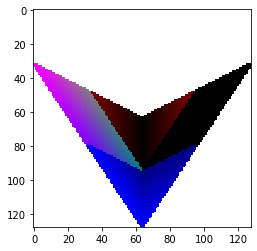

In [220]:
def draw_model_tile(tridata, subdiv=128, tiles_scale=1, hfactor=1.5, show_floor=True, angle=0.):
    xbase = 0
    ybase = 0

    sin_angle = math.sin(angle)
    cos_angle = math.cos(angle)
    cpls_angle = cos_angle + sin_angle
    cmns_angle = cos_angle - sin_angle
    radius_x = (iso_base_w * tiles_scale / 2)
    radius_y = (iso_base_h * tiles_scale / 2)
    max_z = 32 * hfactor

    print(f"sin_angle = {sin_angle}, cos_angle = {cos_angle}, cpls_angle = {cpls_angle}, cmns_angle = {cmns_angle}")

    img = Image.new('RGBA', (iso_base_w * tiles_scale, iso_base_h * tiles_scale * 2), (0, 0, 0, 0))
    pixels = img.load()

    x0 = radius_x * (1. + sin_angle)
    y0 = img.size[1] - radius_y * (1. - cos_angle)

    max_hc = subdiv
    for hc in range(0, max_hc):
        #print(f"hc = {hc}")
        h = float(hc / max_hc)

        max_vc = subdiv
        for raw_vc in range(max_vc):
            if cmns_angle >= 0:  vc = raw_vc
            else:                vc = max_vc - raw_vc - 1
            v = 1. - float(vc / max_vc)

            max_uc = subdiv
            for raw_uc in range(max_uc):
                if cpls_angle >= 0:  uc = raw_uc
                else:                uc = max_uc - raw_uc - 1
                u = 1. - float(uc / max_uc)

                e = 0
                if h > 0.99 or h < 0.01: e += 1
                if u > 0.99 or u < 0.01: e += 1
                if v > 0.99 or v < 0.01: e += 1
                if e >= 2:
                    alpha = 0.5
                    nr, ng, nb = 0, 0, 128
                else:
                    alpha = 0.
                    nr, ng, nb = 0, 0, 0
                
                point = np.array((u, v, h))
                for main_plane, side_planes, mapping_data, colors_map, texture_map in tridata:
                    d = np.dot(main_plane[0], point) + main_plane[1]
                    if abs(d) < .02:
                        out = False
                        for p in side_planes:
                            if np.dot(p[0], point) + p[1] < 0:
                                out = True
                        if not out:
                            p0, M = mapping_data
                            projA, projB, projC = np.dot(M, point - p0)
                            assert (projA >= 0. and projA <= 1.)
                            assert (projB >= 0. and projB <= 1.)
                            alpha = 1.
                            nr, ng, nb, alpha = 255 * (colors_map[0] + \
                                projA * colors_map[1] + projB * colors_map[2])
                            tu, tv = (texture_map[0] + \
                                projA * texture_map[1] + projB * texture_map[2])

                if alpha < 1:
                    continue
                            
                x = x0 + radius_x * (u * cmns_angle - v * cpls_angle)
                y = y0 - radius_y * (u * cpls_angle + v * cmns_angle)
                z = h * max_z

                tx = int(xbase + x)
                ty = int(ybase + y - z)
                
                pixels[tx, ty] = (int(nr), int(ng), int(nb), int(alpha))

    return img

img = draw_model_tile(tridata=tridata, tiles_scale=1, hfactor=2.0, show_floor=True, angle = 2 * math.pi/4.)
plt.imshow(img)
plt.show()
